In [34]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Threat data

In [2]:
# dataset present in site https://data.world/crowdflower/image-sentiment-polarity/workspace/file?filename=image-Sentiment-polarity-DFE.csv
dataframe = pd.read_csv('image-Sentiment-polarity-DFE.csv')
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15613 entries, 0 to 15612
Data columns (total 10 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   _unit_id                                                                        15613 non-null  int64  
 1   _golden                                                                         15613 non-null  bool   
 2   _unit_state                                                                     15613 non-null  object 
 3   _trusted_judgments                                                              15613 non-null  int64  
 4   _last_judgment_at                                                               14999 non-null  object 
 5   which_of_these_sentiment_scores_does_the_above_image_fit_into_best              15613 non-null  object 
 6   which_of_these

In [3]:
dataframe

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,which_of_these_sentiment_scores_does_the_above_image_fit_into_best,which_of_these_sentiment_scores_does_the_above_image_fit_into_best:confidence,imageurl,which_of_these_sentiment_scores_does_the_above_image_fit_into_best_gold,which_of_these_sentiment_scores_does_the_above_image_fit_into_best_gold_reason
0,694550568,True,golden,47,NaN,Positive,0.6395,http://farm1.staticflickr.com/20/71235476_3103...,Highly positive\nPositive,"He is smiling. => happy, joy"
1,694550569,True,golden,36,NaN,Positive,0.6458,http://farm4.staticflickr.com/3096/2584485524_...,Highly positive\nPositive,A beautiful scenery. => serenity
2,694550570,True,golden,35,NaN,Negative,0.8420,http://farm3.staticflickr.com/2880/11733997835...,Negative\nHighly negative,"They look serious. => sadness, fear"
3,694550571,True,golden,41,NaN,Positive,0.7216,http://farm4.staticflickr.com/3022/2286937150_...,Highly positive\nPositive,"A cute puppy. => happy, joy"
4,694550572,True,golden,46,NaN,Positive,0.8801,http://farm1.staticflickr.com/163/357381033_d0...,Highly positive\nPositive,"She looks fun. => fun, joy, happy"
...,...,...,...,...,...,...,...,...,...,...
15608,694566363,False,finalized,3,3/26/15 1:59,Positive,0.6705,http://farm3.static.flickr.com/2198/1572103607...,NaN,NaN
15609,694566364,False,finalized,3,3/26/15 2:13,Positive,0.3373,http://farm1.static.flickr.com/100/263134442_6...,NaN,NaN
15610,694566365,False,finalized,3,3/26/15 2:54,Positive,0.6663,http://farm2.static.flickr.com/1360/1392747419...,NaN,NaN
15611,694566366,False,finalized,3,3/26/15 2:46,Negative,0.6760,http://farm3.static.flickr.com/2077/1925076121...,NaN,NaN


<AxesSubplot:>

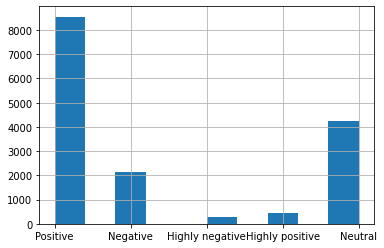

In [5]:
# histogram of positive and negative images
dataframe['which_of_these_sentiment_scores_does_the_above_image_fit_into_best'].hist()

In [7]:
sentimental_label_classify = dataframe[
    'which_of_these_sentiment_scores_does_the_above_image_fit_into_best'
]

In [8]:
sentimental_label_classify.unique()

array(['Positive', 'Negative', 'Highly negative', 'Highly positive',
       'Neutral'], dtype=object)

In [22]:
def plot_pie_chart_count_sentiments(sentiment_count):
    fig1, ax1 = plt.subplots()
    ax1.pie(
        sentiment_count.values(), 
        labels=list(sentiment_count.keys()), 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90
    )
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

### Distribution classify labels 

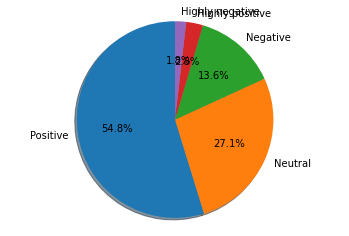

In [23]:
sentiment_count = dict(sentimental_label_classify.value_counts())
plot_pie_chart_count_sentiments(sentiment_count)

In [26]:
dataframe['sentiment'] = dataframe['which_of_these_sentiment_scores_does_the_above_image_fit_into_best']
dataframe['sentiment'].replace({"Highly negative": "Negative", "Highly positive": "Positive"}, inplace=True)

In [27]:
dataframe['sentiment'].unique()

array(['Positive', 'Negative', 'Neutral'], dtype=object)

### Distribution after eliminate classify labels 

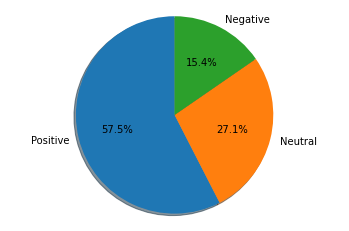

In [28]:
sentiment_count = dict(dataframe['sentiment'].value_counts())
plot_pie_chart_count_sentiments(sentiment_count)

In [43]:
X = dataframe['imageurl']
y = dataframe['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({'Positive': 8087, 'Neutral': 3812, 'Negative': 2152})
Testing target statistics: Counter({'Positive': 897, 'Neutral': 415, 'Negative': 250})


## Balancing the dataset

In [46]:
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X_train.values.reshape(-1, 1), y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({'Negative': 2152, 'Neutral': 2152, 'Positive': 2152})
Testing target statistics: Counter({'Positive': 897, 'Neutral': 415, 'Negative': 250})
